In [1051]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
'''Transformer(iTransformer)で時系列予測を行う'''

'Transformer(iTransformer)で時系列予測を行う'

In [1052]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
print(keras.backend.backend())

tensorflow


In [1053]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

In [1054]:
# 乱数固定
SEED = 20241001
keras.utils.set_random_seed(SEED)
import os
os.environ['PYTHONHASHSEED'] = str(SEED)
import numpy as np
np.random.seed(SEED)
import random
random.seed(SEED)
import tensorflow as tf
tf.random.set_seed(SEED)

In [1055]:
# 定数
BATCH_SIZE = 12	# ミニバッチのサイズ
EPOCHS = 100	# 学習回数(1〜)
N_TEST = 12	# 最後のこの月数分を予測する
TIMESTEPS_IN = 15	# 入力時系列長
TIMESTEPS_OUT =4	# 出力時系列長

In [1056]:
# データを生成する関数
def make_data(X):
    # 念のためnp.arrayに変換
    x = np.asarray(X) if X.ndim	> 1 else np.asarray(X).reshape(-1, 1)

    # x+yの配列に変換
    x = np.asarray([x[i:i+TIMESTEPS_IN+TIMESTEPS_OUT] for i in range(len(x)-TIMESTEPS_IN-TIMESTEPS_OUT+1)])

    # BATCH_SIZEの倍数になるよう先頭を切り捨て
    x = np.asarray(x[len(x)%BATCH_SIZE:])

    # xとyに分離
    x_data = x[:, :TIMESTEPS_IN].reshape(-1, TIMESTEPS_IN, x.shape[-1])
    y_data = x[:, -TIMESTEPS_OUT:].reshape(-1, TIMESTEPS_OUT, x.shape[-1])

    # train, testに分割
    x_train = x_data[:-N_TEST]
    y_train = y_data[:-N_TEST]
    x_test = x_data[-N_TEST:]
    y_test = y_data[-N_TEST:]

    return (x_train, y_train), (x_test, y_test)

In [1057]:
# Transformer
def transformer_encoder(inputs, num_heads, key_dim, mh_dropout, dropout, mlp_units, mlp_dropout):
    # Attention and Normalization
    x = keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=key_dim, dropout=mh_dropout
    )(inputs, inputs)

    x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
    x = keras.layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = keras.layers.LayerNormalization(epsilon=1e-6)(res)
    x = keras.layers.Dense(mlp_units, activation='gelu')(x)
    x = keras.layers.Dropout(mlp_dropout)(x)
    x = keras.layers.Dense(inputs.shape[-1])(x)
    return x + res

In [1058]:
# モデルを構築する関数
def make_model(num_transformer_blocks, num_heads, key_dim, mh_dropout, dropout, mlp_units, mlp_dropout, dropout_out):
    inputs = keras.layers.Input(batch_shape=(BATCH_SIZE, TIMESTEPS_IN, 1))
    x = keras.layers.Permute(dims=(2,1))(inputs)
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(inputs=x, num_heads=num_heads, key_dim=key_dim, mh_dropout=mh_dropout, dropout=dropout, mlp_units=mlp_units, mlp_dropout=mlp_dropout)

    x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
    x = keras.layers.Dropout(dropout_out)(x)
    x = keras.layers.Dense(TIMESTEPS_OUT)(x)

    outputs = keras.layers.Permute(dims=(2,1))(x)

    model = keras.models.Model(inputs=inputs, outputs=outputs)
    return model

In [1059]:
# データ読み込み
df = pd.read_csv('data/international-airline-passengers.csv', engine='python', skipfooter=3)
df_p = df['passengers']

In [1060]:
# 標準化
std = df_p.std()
mean = df_p.mean()
df_s = (df_p - mean) / std

In [1061]:
# データ整形
(x_train, y_train), (x_test, y_test) = make_data(df_s)
print(f'{x_train.shape=}, {y_train.shape=}, {x_test.shape=}, {y_test.shape=}')

x_train.shape=(108, 15, 1), y_train.shape=(108, 4, 1), x_test.shape=(12, 15, 1), y_test.shape=(12, 4, 1)


In [1062]:
# ハイパーパラメータ
num_transformer_blocks = 3
num_heads =3
key_dim = 3
mh_dropout = 0.1
dropout = 0.1
mlp_units = 80
mlp_dropout = 0.2
dropout_out = 0.1
learning_rate = 0.01

In [1063]:
# モデル構築
model = make_model(
    num_transformer_blocks=num_transformer_blocks,
    num_heads=num_heads,
    key_dim=key_dim,
    mh_dropout=mh_dropout,
    dropout=dropout,
    mlp_units=mlp_units,
    mlp_dropout=mlp_dropout,
    dropout_out=dropout_out,
)

In [1064]:
# 学習ループ構築
model.compile(optimizer=keras.optimizers.AdamW(learning_rate=learning_rate, clipnorm=0.001), loss=keras.losses.LogCosh(), metrics=['mse'])

In [1065]:
# モデルの表示
keras.utils.plot_model(model, to_file='model.png')
model.summary()

Model: "functional_50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_50      │ (12, 15, 1)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_100         │ (12, 1, 15)       │          0 │ input_layer_50[0… │
│ (Permute)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (12, 1, 15)       │        582 │ permute_100[0][0… │
│ (MultiHeadAttentio… │                   │            │ permute_100[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (12, 1, 15)       │         30 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_252         │ (12, 1, 15)       │          0 │ layer_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_134 (Add)       │ (12, 1, 15)       │          0 │ dropout_252[0][0… │
│                     │                   │            │ permute_100[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (12, 1, 15)       │         30 │ add_134[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_184 (Dense)   │ (12, 1, 80)       │      1,280 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_253         │ (12, 1, 80)       │          0 │ dense_184[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_185 (Dense)   │ (12, 1, 15)       │      1,215 │ dropout_253[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_135 (Add)       │ (12, 1, 15)       │          0 │ dense_185[0][0],  │
│                     │                   │            │ add_134[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (12, 1, 15)       │        582 │ add_135[0][0],    │
│ (MultiHeadAttentio… │                   │            │ add_135[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (12, 1, 15)       │         30 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_255         │ (12, 1, 15)       │          0 │ layer_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_136 (Add)       │ (12, 1, 15)       │          0 │ dropout_255[0][0… │
│                     │                   │            │ add_135[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (12, 1, 15)       │         30 │ add_136[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_186 (Dense)   │ (12, 1, 80)       │      1,280 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_256         │ (12, 1, 80)       │          0 │ dense_186[0][0] 

 Total params: 9,505 (37.13 KB)

 Trainable params: 9,505 (37.13 KB)

 Non-trainable params: 0 (0.00 B)

In [1066]:
# 学習
model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0, shuffle=True)

Epoch 1/100


c:\Users\T123011\jupyter_examples\3.12\Lib\site-packages\keras\src\ops\nn.py:908: UserWarning: You are using a softmax over axis 3 of a tensor of shape (12, 3, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.4382 - mse: 1.2486
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1540 - mse: 0.3528
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1026 - mse: 0.2244
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0878 - mse: 0.1882
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0820 - mse: 0.1756
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0511 - mse: 0.1075
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0521 - mse: 0.1103
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0512 - mse: 0.1082
Epoch 9/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0471 - mse: 0.0985
Epoch 10/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0399 - mse: 0.0829
Epoch 11/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0316 - mse: 0.0655
Epoch 12/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0416 - mse: 0.0887
Epoch 13/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0

In [1067]:
# 予測
p_train = model.predict(x_train, batch_size=BATCH_SIZE)
p_test = model.predict(x_test, batch_size=BATCH_SIZE)
print(f'{p_train.shape=}, {p_test.shape=}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
p_train.shape=(108, 4, 1), p_test.shape=(12, 4, 1)


In [1068]:
# 精度を計算
loss = mean_squared_error(y_train.flatten(), p_train.flatten())
test_loss = mean_squared_error(y_test.flatten(), p_test.flatten())
print(f'{loss=}, {test_loss=}')

loss=0.01914299545904456, test_loss=0.3100682656125749


In [1069]:
# 横軸
time = range(len(df))

In [1070]:
# 1次元にし、標準化を元に戻す
p_train = p_train[:,-1,:].flatten() * std + mean
p_test = p_test[:,-1,:].flatten() * std + mean

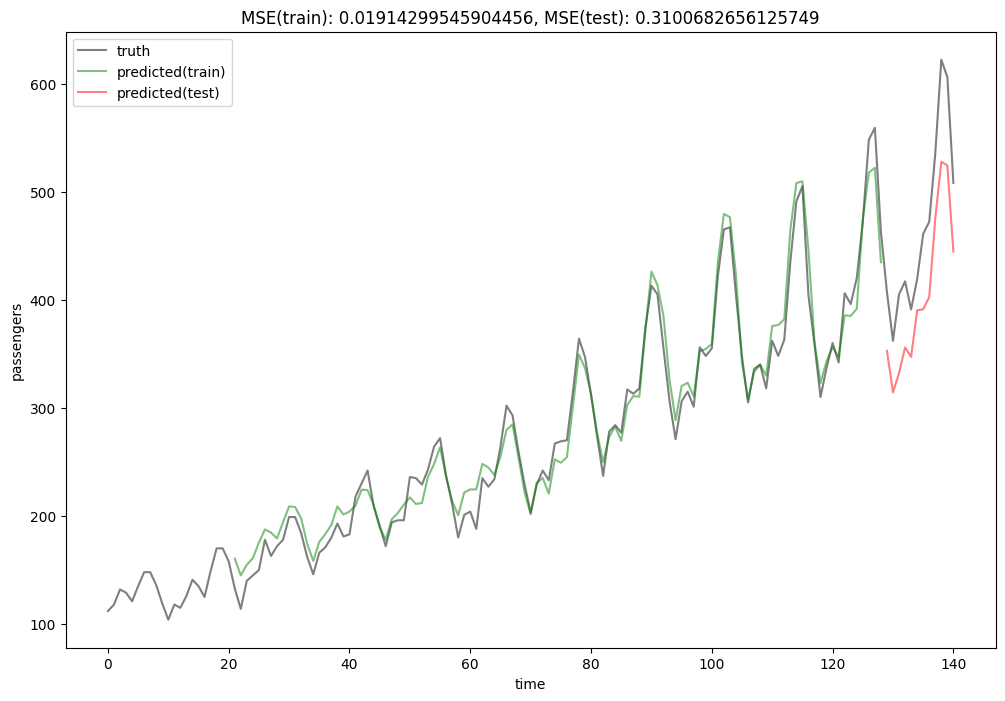

In [1071]:
# グラフの描画およびファイル保存
fig = plt.figure(figsize=(12, 8))
plt.subplot(111)
plt.plot(time, df_p, color='k', label='truth', alpha=0.5)
plt.plot(time[-len(p_train)-len(p_test):-len(p_test)], p_train, color='g', label='predicted(train)', alpha=0.5)
plt.plot(time[-len(p_test):], p_test, color='r', label='predicted(test)', alpha=0.5)
plt.xlabel('time')
plt.ylabel('passengers')
plt.title(f'MSE(train): {loss}, MSE(test): {test_loss}')
#plt.legend(bbox_to_anchor=(0, 0), loc='upper left', borderaxespad=0)
plt.legend()
plt.subplots_adjust(hspace=0.5)
plt.savefig('plot.png') # ファイル出力
plt.show() # コマンドラインからの実行の場合に描画する(jupyterの場合は既に描画済みなので何も出ません)